In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Data preparation

### 1.1 Load data

In [2]:
df = pd.read_csv('data/data_science.csv', index_col=0)
df.head()

,Name,Title,Country,Rate,Earnings,Success,Badges,Description
0,Ismail T.,Data Strategy Consultant | Data Solutions Expe...,United States,$250.00 /hr,$100k+ earned\n Close the tooltip \...,99% Job Success,"R, Microsoft Excel, Machine Learning, Data Sci...",⭐⭐⭐⭐⭐ 5-Star 𝗧𝗼𝗽 𝗥𝗮𝘁𝗲𝗱 𝗣𝗹𝘂𝘀 Data Professional\...
1,Callum H.,Data Scientist: quantitative and qualitative d...,South Africa,$40.00 /hr,$10k+ earned\n Close the tooltip \n...,100% Job Success,"Data Science, Data Mining, Data Cleansing, Dat...",Greetings! I am a data scientist who lives in ...
2,Mohammed Z.,Data Scientist,United States,$85.00 /hr,NaN,100% Job Success,"Data Science, Machine Learning, Data Analytics...",Do you need a Data Scientist or a Data Enginee...
3,Luiz T.,Data Scientist and Machine Learning specialist,Brazil,$85.00 /hr,$40k+ earned\n Close the tooltip \n...,100% Job Success,"Python, Machine Learning, Data Science, Data A...",I am a trained computer scientist passionate a...
4,Ahmed A.,Machine Learning | Deep Learning | NLP Engineer,Egypt,$60.00 /hr,NaN,100% Job Success,"Python, Data Science, Scripting, Algorithms, N...","Hello there,\n\nThis is Ahmed, a Machine Learn..."


### 1.2 Clean columns

#### 1.2.1 Convert `Rates` column from string to float

In [3]:
df.sample(50).Rate.unique()

array(['$75.00   /hr', '$55.00   /hr', '$50.00   /hr', '$120.00   /hr',
       '$16.00   /hr', '$20.00   /hr', '$10.00   /hr', '$40.00   /hr',
       '$8.00   /hr', '$15.00   /hr', '$13.00   /hr', '$5.00   /hr',
       '$4.00   /hr', '$125.00   /hr', '$175.00   /hr', '$85.00   /hr',
       '$65.00   /hr', '$70.00   /hr', '$45.00   /hr', '$80.00   /hr',
       '$35.00   /hr', '$30.00   /hr', '$17.00   /hr', '$21.00   /hr',
       '$6.00   /hr'], dtype=object)

In [4]:
# transport Rates columns into float dollars per hour
df.Rate = df.Rate.apply(lambda x: x.split('   /')[0][1:]).astype(float)
df.Rate.head()

0    250.0
1     40.0
2     85.0
3     85.0
4     60.0
Name: Rate, dtype: float64

#### 1.2.2 Create new `Total_earnings` column from `Earnings` column

In [5]:
df.Earnings.head()[0]

'$100k+ earned\n           Close the tooltip  \n            48\n            hourly jobs\n           \n            28\n            fixed-price jobs\n           \n            1215\n            hours worked'

In [6]:
# convert column to string
df.Earnings = df.Earnings.astype(str)
# extract earnings value from column
df['Total_Earnings'] = df.Earnings.apply(lambda x: x.split('\n')[0][1:-8] if 'earned' in x else '0')
# multiply by 100 if k is present in string
df.Total_Earnings = df.Total_Earnings.apply(lambda x: int(x[:-1])*1000 if 'k' in x else int(x))
df.Total_Earnings.head()

0    100000
1     10000
2         0
3     40000
4         0
Name: Total_Earnings, dtype: int64

#### 1.2.3 Create new `Hourly_jobs`, `Fixed_price_jobs`, column from `Earnings` column

In [7]:
# check if all length of row is the same for all cases
df.Earnings.apply(lambda x: len(x.split('\n')) if 'fixed-price jobs' in x else 0).unique()

array([10,  0], dtype=int64)

In [8]:
df['Hourly_jobs'] = df.Earnings.apply(lambda x: x.split('\n')[2].strip() if 'hourly jobs' in x else '0')
df['Fixed_price_jobs'] = df.Earnings.apply(lambda x: x.split('\n')[5].strip() if 'fixed-price jobs' in x else '0')
# convert strings, eg. 'No', to integer
df.Hourly_jobs = df.Hourly_jobs.apply(lambda x: int(x) if x.isnumeric() else 0)
df.Fixed_price_jobs = df.Fixed_price_jobs.apply(lambda x: int(x) if x.isnumeric() else 0)

df['Hours_worked'] = df.Earnings.apply(lambda x: x.split('\n')[-2].strip() if 'hours worked' in x else 0)
df[['Hourly_jobs', 'Fixed_price_jobs', 'Hours_worked']].sample(5)

,Hourly_jobs,Fixed_price_jobs,Hours_worked
328,13,13,6971
410,15,69,198
408,0,0,0
450,0,0,71
409,6,2,434


### 1.3 One-hot-encode

#### 1.3.1 `bages` columns

In [9]:
df_bages = df.Badges.str.get_dummies(sep=',')
df_bages.head()

,.NET Framework,3D Design,3D Modeling,3D Rendering,3D Visualization,A/B Testing,ADO.NET,AI,APEX,API,...,Technical Writing,Twitter API,VBA,Video Production,Virtual Assistant,Web Design,Web Research,Web Scraper,Website Development,XMPP
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df = pd.concat([df, df_bages], axis=1)
df.head()

,Name,Title,Country,Rate,Earnings,Success,Badges,Description,Total_Earnings,Hourly_jobs,...,Technical Writing,Twitter API,VBA,Video Production,Virtual Assistant,Web Design,Web Research,Web Scraper,Website Development,XMPP
0,Ismail T.,Data Strategy Consultant | Data Solutions Expe...,United States,250.0,$100k+ earned\n Close the tooltip \...,99% Job Success,"R, Microsoft Excel, Machine Learning, Data Sci...",⭐⭐⭐⭐⭐ 5-Star 𝗧𝗼𝗽 𝗥𝗮𝘁𝗲𝗱 𝗣𝗹𝘂𝘀 Data Professional\...,100000,48,...,0,0,0,0,0,0,0,0,0,0
1,Callum H.,Data Scientist: quantitative and qualitative d...,South Africa,40.0,$10k+ earned\n Close the tooltip \n...,100% Job Success,"Data Science, Data Mining, Data Cleansing, Dat...",Greetings! I am a data scientist who lives in ...,10000,11,...,0,0,0,0,0,0,0,0,0,0
2,Mohammed Z.,Data Scientist,United States,85.0,nan,100% Job Success,"Data Science, Machine Learning, Data Analytics...",Do you need a Data Scientist or a Data Enginee...,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Luiz T.,Data Scientist and Machine Learning specialist,Brazil,85.0,$40k+ earned\n Close the tooltip \n...,100% Job Success,"Python, Machine Learning, Data Science, Data A...",I am a trained computer scientist passionate a...,40000,9,...,0,0,0,0,0,0,0,0,0,0
4,Ahmed A.,Machine Learning | Deep Learning | NLP Engineer,Egypt,60.0,nan,100% Job Success,"Python, Data Science, Scripting, Algorithms, N...","Hello there,\n\nThis is Ahmed, a Machine Learn...",0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Data analysis

### 2.1 hourly rates vs country

In [11]:
# get top 10 most and least paid countrys 
top_10_min = df.groupby('Country')['Rate'].median().sort_values().head(10).index
top_10_max = df.groupby('Country')['Rate'].median().sort_values().tail(10).index

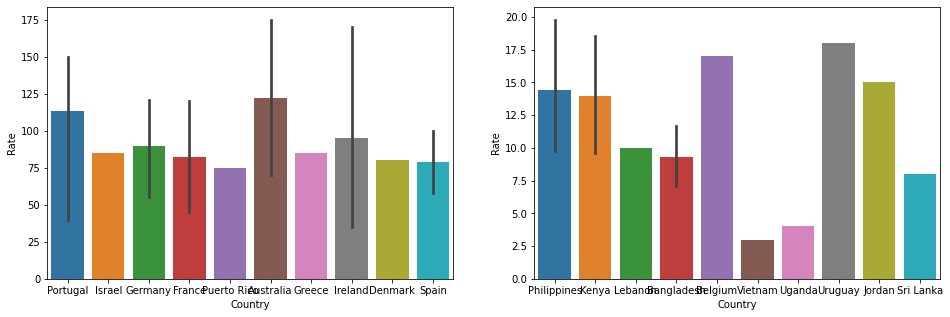

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(x='Country', y='Rate', data=df.loc[df.Country.isin(top_10_max)], ax=ax1);

sns.barplot(x='Country', y='Rate', data=df.loc[df.Country.isin(top_10_min)], ax=ax2);